# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se suponen en el directorio data/COVID-19

## Actualización de ficheros

Se actualizarán, vía git, los ficheros csv

In [1]:
! cd data/COVID-19; git pull
! ls -l data/COVID-19/csse_covid_19_data/csse_covid_19_time_series

remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16 (delta 10), reused 16 (delta 10), pack-reused 0
Unpacking objects: 100% (16/16), 63.23 KiB | 224.00 KiB/s, done.
From https://github.com/CSSEGISandData/COVID-19
   387dccf93..9aefa4af0  web-data   -> origin/web-data
Already up to date.
total 8344
-rw-r--r-- 1 10001 10001   73792 Jan  2 12:10 Errata.csv
-rw-r--r-- 1 10001 10001    1692 Jan  2 12:10 README.md
-rw-r--r-- 1 10001 10001  421450 Jan  5 12:18 time_series_covid19_confirmed_global.csv
-rw-r--r-- 1 10001 10001 4271065 Jan  5 12:18 time_series_covid19_confirmed_US.csv
-rw-r--r-- 1 10001 10001  293514 Jan  5 12:18 time_series_covid19_deaths_global.csv
-rw-r--r-- 1 10001 10001 3091872 Jan  5 12:18 time_series_covid19_deaths_US.csv
-rw-r--r-- 1 10001 10001  377941 Jan  5 12:18 time_series_covid19_recovered_global.csv


## Importación de datos
Lo primero es común a todos los programas que traten datos

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos y de casso confirmados

In [3]:
df_deaths = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col=[0,1,2,3])
df_confirmed = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col=[0,1,2,3])

In [4]:
df_deaths.head()

1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/31/20  ...  12/26/20  \
Province/State Country/Region Lat       Long                ...             
NaN            Afghanistan     33.93911 67.709953        0  ...      2149   
               Albania         41.15330 20.168300        0  ...      1143   
               Algeria         28.03390 1.659600         0  ...      2722   
               Andorra         42.50630 1.521800         0  ...        83   
               Angola         -11.20270 17.873900        0  ...       399   

                                                   12/27/20  12/28/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953      2160      2174   
               Albania         41.15330 20.168300      1153      1164   
               Algeria         28.03390 1.659600       2728      2737   
               Andorra         42.50630 1.521800         83        83   
               Angola         -11.20270 17.873900       399       403   

                                                   12/29/20  12/30/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953      2179      2181   
               Albania         41.15330 20.168300      1170      1174   
               Algeria         28.03390 1.659600       2745      2751   
               Andorra         42.50630 1.521800         84        84   
               Angola         -11.20270 17.873900       403       405   

                                                   12/31/20  1/1/21  1/2/21  \
Province/State Country/Region Lat       Long                                  
NaN            Afghanistan     33.93911 67.709953      2191    2191    2191   
               Albania         41.15330 20.168300      1181    1181    1190   
               Algeria         28.03390 1.659600       2756    2762    2769   
               Andorra         42.50630 1.521800         84      84      84   
               Angola         -11.20270 17.873900       405     405     407   

                                                   1/3/21  1/4/21  
Province/State Country/Region Lat       Long                       
NaN            Afghanistan     33.93911 67.709953    2191    2237  
               Albania         41.15330 20.168

In [5]:
df_confirmed.head()

1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/31/20  ...  12/26/20  \
Province/State Country/Region Lat       Long                ...             
NaN            Afghanistan     33.93911 67.709953        0  ...     50886   
               Albania         41.15330 20.168300        0  ...     55755   
               Algeria         28.03390 1.659600         0  ...     97857   
               Andorra         42.50630 1.521800         0  ...      7806   
               Angola         -11.20270 17.873900        0  ...     17149   

                                                   12/27/20  12/28/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953     51039     51280   
               Albania         41.15330 20.168300     56254     56572   
               Algeria         28.03390 1.659600      98249     98631   
               Andorra         42.50630 1.521800       7821      7875   
               Angola         -11.20270 17.873900     17240     17296   

                                                   12/29/20  12/30/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953     51350     51405   
               Albania         41.15330 20.168300     57146     57727   
               Algeria         28.03390 1.659600      98988     99311   
               Andorra         42.50630 1.521800       7919      7983   
               Angola         -11.20270 17.873900     17371     17433   

                                                   12/31/20  1/1/21  1/2/21  \
Province/State Country/Region Lat       Long                                  
NaN            Afghanistan     33.93911 67.709953     51526   51526   51526   
               Albania         41.15330 20.168300     58316   58316   58991   
               Algeria         28.03390 1.659600      99610   99897  100159   
               Andorra         42.50630 1.521800       8049    8117    8166   
               Angola         -11.20270 17.873900     17553   17568   17608   

                                                   1/3/21  1/4/21  
Province/State Country/Region Lat       Long                       
NaN            Afghanistan     33.93911 67.709953   51526   53011  
               Albania         41.15330 20.168

## Tratamiento de datos
Se hace una agrupamiento por país (level=1) y una transposición de forma que los países aparezcan como columnas y los días como filas

In [6]:
deaths_covid = df_deaths.groupby(level=1).sum().transpose()
confirmed_covid = df_confirmed.groupby(level=1).sum().transpose()


In [7]:
deaths_covid.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
confirmed_covid.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,2,0,0,0,0


Los ficheros csv contienen cifras acumuladas. Vamos a ver los incrementos diarios con la función diff

In [9]:
deaths_covid_inc = deaths_covid.diff()
confirmed_covid_inc =confirmed_covid.diff()

In [10]:
deaths_covid_inc.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
confirmed_covid_inc.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados muestreados por semanas (resampling = '7D') ya que se ha comprobado
que los datos presentan fuerte correlación con el día de la semana. De esta forma se evitan dientes de sierra. 

Para evitar que el muestreo no deje el último valor con menos de 7 sumandos, se utiliza como punto de partida del gráfico, el día
de hoy menos nweeks semanas. Cambiando este número, el gráfico abarca un periodo más o menos largo

Los países para los cuales se desean los gráficos están en el array interesting_countries.

El último dato es el de la fecha en la que se ejecuta el notebook (todate = today). El primero de los datos se pone a mano.
En una versión posterior podría ser un número de semanas o meses y hacer que fromdate sea today - datetime.timedelta(days=xx).por ejemplo.

La escala en y puede ser logarítimca (logaritmic = True) o no (logaritmic = False)

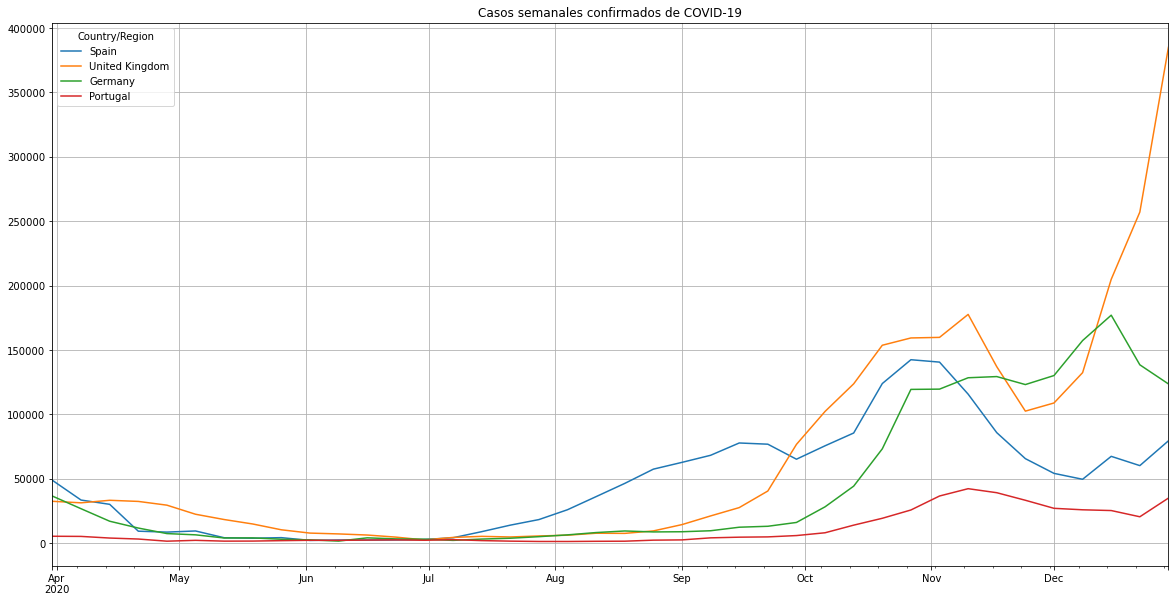

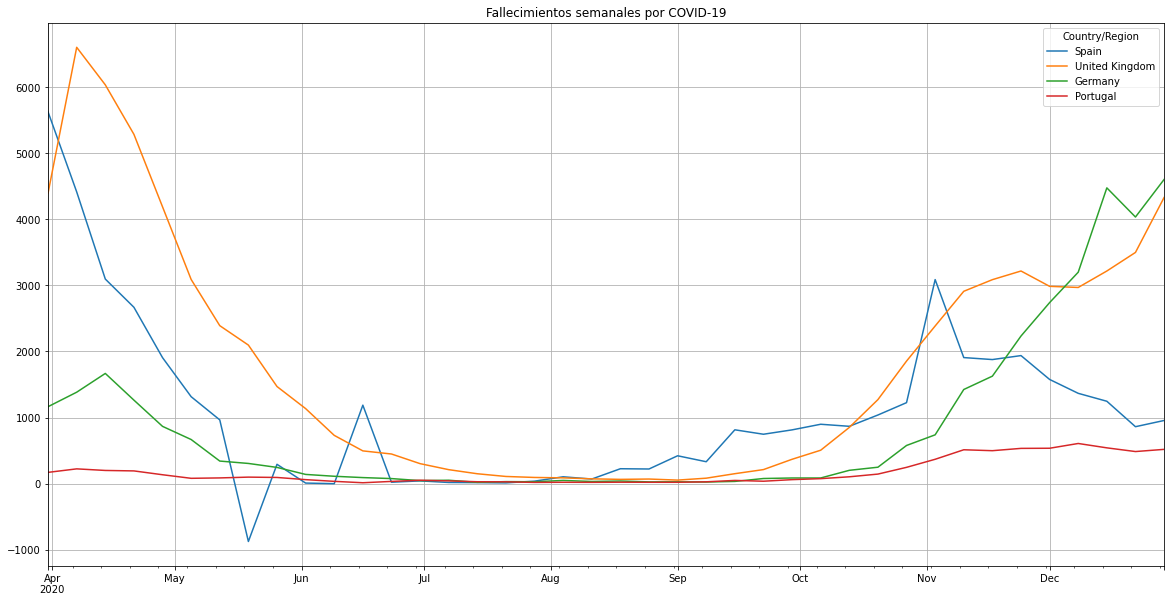

In [34]:
import datetime

deaths_covid_inc.index = pd.to_datetime(deaths_covid_inc.index)
confirmed_covid_inc.index = pd.to_datetime(confirmed_covid_inc.index)

#interesting_countries = ['Spain','France','United Kingdom', 'Chile', 'Germany']
interesting_countries = ['Spain','United Kingdom', 'Germany', 'Portugal' ]

#fromdate='3/15/20'
# 
nweeks = 40
today = datetime.date.today()
#yesterday = today - datetime.timedelta(days=1)
fromdate=today - datetime.timedelta(weeks=nweeks)
todate=today.strftime("%m/%d/%y")

resampling = '7D'
fsize = (20,10)
logaritmic = False

axc = confirmed_covid_inc[interesting_countries].loc[fromdate:todate].resample(resampling).sum().plot(title='Casos semanales confirmados de COVID-19', 
                                                                        figsize=fsize, 
                                                                        logy=logaritmic,
                                                                        grid=True
                                                                        )
axd = deaths_covid_inc[interesting_countries].loc[fromdate:todate].resample(resampling).sum().plot(title='Fallecimientos semanales por COVID-19', 
                                                                        figsize=fsize, 
                                                                        logy=logaritmic,
                                                                        grid=True                                                                      
                                                                       )